## Repositório

[Tópicos Avançados em Inteligência Computacional 2](https://github.com/Manuelfjr/topicos_avancados_ic_ii/tree/develop)

## Atividade 03

**[Global Surrogates]**

descrição:

1. Leitura para a próxima aula (dia 18): Capítulo "Interpretable Models" e "Global Surrogate" (pag 163) do livro do Molnar. A leitura é para discussão em sala;


2. Treinem um modelo caixa-preta (e.g., Random Forest) para uma base de dados do seu interesse. Crie um global surrogate caixa-branca (e.g., árvore de decisão), que simule esse modelo caixa-preta aprendido. Façam o upload do notebook.

Obs.: Podem reusar o notebook disponibilizado no material da aula.

## Introdução

informações: 
A base utilizada será a mesma da atividade `01`.

* **dataset**:  Breast cancer wisconsin (diagnostic)

* **Attribute Information**:
    - radius (mean of distances from center to points on the perimeter)

    - texture (standard deviation of gray-scale values)

    - perimeter

    - area

    - smoothness (local variation in radius lengths)

    - compactness (perimeter^2 / area - 1.0)

    - concavity (severity of concave portions of the contour)

    - concave points (number of concave portions of the contour)

    - symmetry

    - fractal dimension (“coastline approximation” - 1)

The mean, standard error, and “worst” or largest (mean of the three worst/largest values) of these features were computed for each image, resulting in 30 features. For instance, field 0 is Mean Radius, field 10 is Radius SE, field 20 is Worst Radius.

* **class**:
    - WDBC-Malignant (1)
    - WDBC-Benign (0)

## Descrição

Durante o decorrer da atividade, será utilizado como *Global surrogate* o model caixa branca *Decision Tree*, variando a profundidade da arvore entre 1 e 3, com o intuito de analisar a aproximação para com o modelo caixa preta; e para modelo caixa preta, serão considerados o *Random Forest* e o *SVC*.

## Objetivo

Criar um modelo de caixa branca (*Decision Tree*) para aproximar um modelo de caixa preta.

## 0. Basics

### 0.1 Imports

In [71]:
# datasets
import warnings
from typing import Dict, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# utils
from nb_utils import set_root
from sklearn.datasets import load_breast_cancer, make_circles
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
# model
from sklearn.tree import DecisionTreeClassifier, plot_tree

PROJECT_DIR = set_root(return_path=True)

warnings.filterwarnings('ignore')

### 0.2 Methods

In [72]:
def add_pca(
        X_train: Union[pd.DataFrame, np.ndarray],
        X_test: Union[pd.DataFrame, np.ndarray],
        transform: bool = False,
        ncomponents: int = 2
) -> Tuple:
    if not transform:
        return X_train, X_test
    else:
        pca = PCA(ncomponents)
        X_train = pca.fit_transform(X_train)
        X_test = pca.fit_transform(X_test)
        return X_train, X_test


def train_surrogates(
    white_box: dict,
    black_box: dict,
    X_train: Union[pd.DataFrame, np.ndarray],
    y_train: Union[pd.DataFrame, np.ndarray],
    X_test: Union[pd.DataFrame, np.ndarray]
):
    """
    Treina surrogates para aproximar modelos caixa preta.

    Parâmetros:
        white_box (dict): Um dicionário para os surrogates.
        black_box (dict): Um dicionário de modelos caixa preta.
        X_train (DataFrame ou ndarray): Dados de treinamento.
        y_train (DataFrame ou ndarray): Rótulos de treinamento.
        X_test (DataFrame ou ndarray): Dados de teste.

    Retorna:
        Tuple: Um tuple contendo os surrogates treinados, previsões dos modelos
                caixa branca efetua as previsões dos modelos caixa preta.
    """
    black_yhat, white_yhat = {}, {}
    white_box_models = {}

    for w_name, white_model in white_box.items():
        white_yhat[w_name] = {}
        white_box_models[w_name] = {}
        for b_name, black_model in black_box.items():
            black_model.fit(X_train, y_train)
            black_yhat[b_name] = black_model.predict(X_test)

            white_model = white_model.__class__(**white_model.get_params())
            white_model.fit(X_test, black_yhat[b_name])
            white_yhat[w_name][b_name] = white_model.predict(X_test)
            white_box_models[w_name][b_name] = white_model

    return white_box_models, black_box, white_yhat, black_yhat


def plot_results(
    black_yhat: Dict[str, np.ndarray],
    white_yhat: Dict[str, Dict[str, np.ndarray]],
    test_data: np.ndarray,
    tick_params: Dict[str, Union[str, int, float, bool]],
    _names: Dict[str, str],
    show_complete_title: bool = False,
    **kwargs
) -> Tuple[plt.Figure, np.ndarray]:
    """
    Plot o resultado do black box e do white box

    Parameters:
        black_yhat (Dict[str, np.ndarray]): Dicionario de predições par ao modelo black box.
        white_yhat (Dict[str, Dict[str, np.ndarray]]): Dicionario de predicoes para o surrogate.
        test_data (np.ndarray): Dados de teste.
        tick_params (Dict[str, Union[str, int, float, bool]]): tick marks.
        _names (Dict[str, str]): Dicionario para "de para" nos nomes.
        show_complete_title (boolean): Boleano para caso queira mostrar os titulos dos white box completo
        kwargs: parametros para o matplotlib.pyplot.subplots
    Returns:
        Tuple[plt.Figure, np.ndarray]: Tuplca contendo a figura e a imagem.
    """
    fig, axes = plt.subplots(len(black_yhat.keys()), len(white_yhat.keys()) + 1, **kwargs)

    if not isinstance(axes, np.ndarray):
        axes = np.array([[axes]])
    elif axes.ndim == 1:
        axes = axes.reshape(1, -1)

    if axes.shape == ((len(white_yhat.keys()) + 1), ):
        axes = np.array([axes])

    for bidx, (b_name, b_yhat) in enumerate(black_yhat.items()):
        axes[bidx, 0].plot(
            test_data[:, 0][b_yhat == 0], test_data[:, 1][b_yhat == 0], "bs"
        )
        axes[bidx, 0].plot(
            test_data[:, 0][b_yhat != 0], test_data[:, 1][b_yhat != 0], "g^"
        )

        for widx, (w_name, w_model) in enumerate(white_yhat.items()):
            axes[bidx, widx + 1].plot(
                test_data[:, 0][w_model[b_name] == 0], test_data[:, 1][w_model[b_name] == 0], "bs"
            )
            axes[bidx, widx + 1].plot(
                test_data[:, 0][w_model[b_name] != 0], test_data[:, 1][w_model[b_name] != 0], "g^"
            )
            axes[bidx, widx + 1].tick_params(**tick_params)
            if show_complete_title:
                text = f"Surrogate: ${_names[w_name]}"
                text += "_{acc="
                text += f"{round(accuracy_score(b_yhat, w_model[b_name]), 4)}"
                text += "}$"
                axes[bidx, widx + 1].set_title(
                    text
                )
            else:
                text = f"${_names[w_name].split('_')[-1]}"
                text += "_{acc="
                text += f"{round(accuracy_score(b_yhat, w_model[b_name]), 4)}"
                text += "}$"
                axes[bidx, widx + 1].set_title(
                    text
                )

        axes[bidx, 0].tick_params(**tick_params)
        axes[bidx, 0].set_ylabel(r"$x_2$", fontsize=20)

        if bidx == len(black_yhat.items()) - 1:
            for ax in axes[bidx, :]:
                ax.set_xlabel(r"$x_1$", fontsize=20)
        axes[bidx, 0].set_title(f"Black box: {_names[b_name]}")
    plt.close()
    return fig, axes


def plot_simulation_results(
    bs_yhat: Dict[str, np.ndarray],
    ws_yhat: Dict[str, Dict[str, np.ndarray]],
    X_simulated: np.ndarray,
    tick_params: Dict[str, Union[str, int, float, bool]],
    _names: Dict[str, str],
    show_complete_title: bool = False,
    **kwargs
) -> Tuple[plt.Figure, np.ndarray]:
    """
    Plot resultado das simulacoes

    Parâmetros:
        bs_yhat (Dict[str, np.ndarray]): Dicionário de previsões dos modelos black box.
        ws_yhat (Dict[str, Dict[str, np.ndarray]]): Dicionário de previsões do surrogate.
        X_simulated (np.ndarray): Dados simulados.
        tick_params (Dict[str, Union[str, int, float, bool]]): Parâmetros para os marcadores.
        _names (Dict[str, str]): Dicionário mapeando nomes de modelos para nomes conhecidos.
        show_complete_title (boolean): Boleano para caso queira o nome completo do modelo no grafico.
        **kwargs: Argumentos para a função subplots.

    Retorna:
        Tuple[plt.Figure, np.ndarray]: Tupla contendo a figura e os eixos do gráfico.
    """
    fig, axes = plt.subplots(len(bs_yhat.keys()), len(ws_yhat.keys()) + 1, **kwargs)

    if not isinstance(axes, np.ndarray):
        axes = np.array([[axes]])
    elif axes.ndim == 1:
        axes = axes.reshape(1, -1)

    for bidx, (bs_name, s_yhat) in enumerate(bs_yhat.items()):
        axes[bidx, 0].plot(
            X_simulated[:, 0][s_yhat == 0],
            X_simulated[:, 1][s_yhat == 0],
            "bs"
        )
        axes[bidx, 0].plot(
            X_simulated[:, 0][s_yhat != 0],
            X_simulated[:, 1][s_yhat != 0],
            "g^"
        )
        for widx, (ws_name, ws_model) in enumerate(ws_yhat.items()):
            axes[bidx, widx + 1].plot(
                X_simulated[:, 0][ws_model[bs_name] == 0],
                X_simulated[:, 1][ws_model[bs_name] == 0],
                "bs"
            )
            axes[bidx, widx + 1].plot(
                X_simulated[:, 0][ws_model[bs_name] != 0],
                X_simulated[:, 1][ws_model[bs_name] != 0],
                "g^"
            )
            axes[bidx, widx + 1].tick_params(**tick_params)
            if show_complete_title:
                text = f"Surrogate: ${_names[ws_name]}"
                text += "_{acc="
                text += f"{round(accuracy_score(s_yhat, ws_model[bs_name]), 4)}"
                text += "}$"
                axes[bidx, widx + 1].set_title(text)
            else:
                text = f"${_names[ws_name].split('_')[-1]}"
                text += "_{acc="
                text += f"{round(accuracy_score(s_yhat, ws_model[bs_name]), 4)}"
                text += "}$"
                axes[bidx, widx + 1].set_title(text)

        axes[bidx, 0].tick_params(**tick_params)
        axes[bidx, 0].set_ylabel(r"$x_2$", fontsize=20)

        if bidx == len(bs_yhat.items()) - 1:
            for ax in axes[bidx, :]:
                ax.set_xlabel(r"$x_1$", fontsize=20)
        axes[bidx, 0].set_title(f"Black box: {_names[bs_name]}")
    plt.close()
    return fig, axes

### 0.3 Parameters

In [73]:
n_seed = 2024

In [74]:
params = {
    "holdout": {
        "test_size": 0.3,
        "random_state": 2024
    }
}

In [75]:
black_box = {
    "rf": RandomForestClassifier(random_state=n_seed),
    "svc": SVC()
}

In [76]:
white_box = {
    "dt1": DecisionTreeClassifier(max_depth=1, random_state=n_seed),
    "dt2": DecisionTreeClassifier(max_depth=2, random_state=n_seed),
    "dt3": DecisionTreeClassifier(max_depth=3, random_state=n_seed)
}

In [77]:
_names = {
    "rf": "RandomForestClassifier",
    "dt": "DecisionTreeClassifier",
    "svc": "SVC",
    "dt1": r"DecisionTreeClassifier\_max-depth=1",
    "dt2": r"DecisionTreeClassifier\_max-depth=2",
    "dt3": r"DecisionTreeClassifier\_max-depth=3"
}

In [78]:
tick_params = {
    "axis": 'both',
    "which": 'both',
    "bottom": False,
    "top": False,
    "left": False,
    "right": False,
    "labelbottom": False,
    "labelleft": False
}

## 1. Preparando dataset

### 1.1 Leitura

In [79]:
target = "label"
content = load_breast_cancer()
features = list(content["feature_names"])

### 1.2 Process dataset

In [80]:
data = pd.DataFrame(
    content["data"],
    columns=features
)
data[target] = content["target"]
data.columns = (
    data
    .columns
    .str.replace(" ", "_")
    .str.replace("(", "")
    .str.replace(")", "")
)

### 1.3 Split

In [81]:
X = data.drop(target, axis=1).copy()
y = data[target].values

### 1.4 Holdout

aplicação do processo de holdout, considerando um tamanho de teste de `30%`

In [82]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    **params["holdout"]
)

## 2. Modelagem

### 2.1 Fit *black-box* and *white-box* (sem aplicar PCA)

Será treinado o modelo sem aplicar o PCA, para ser possivel uma interpretação direta das variaveis apartir do *white-box* ao final.

In [83]:
X_train, X_test = add_pca(X_train, X_test)

In [84]:
white_box_models, black_box_models, white_yhat, black_yhat = train_surrogates(
    white_box,
    black_box,
    X_train,
    y_train,
    X_test
)

### 2.2 Aplicando *PCA*

Será aplicado o método do *PCA* aoenas representar os dados em $\mathbb{R}^{2}$ e a comparação do método *black box* com o *surrogate*

In [85]:
pca = PCA(2)
pca.fit(X_test)
X_pca = pca.transform(X_test)

### 2.3 Gráficos

In [86]:
fig_bc, axes_bc = plt.subplots(
    len(black_yhat.keys()),
    len(white_box_models.keys()) + 1,
    figsize=(26, 8)
)
plt.close()

In [87]:
if axes_bc.shape == ((len(white_box_models.keys()) + 1), ):
    axes_bc = np.array([axes_bc])

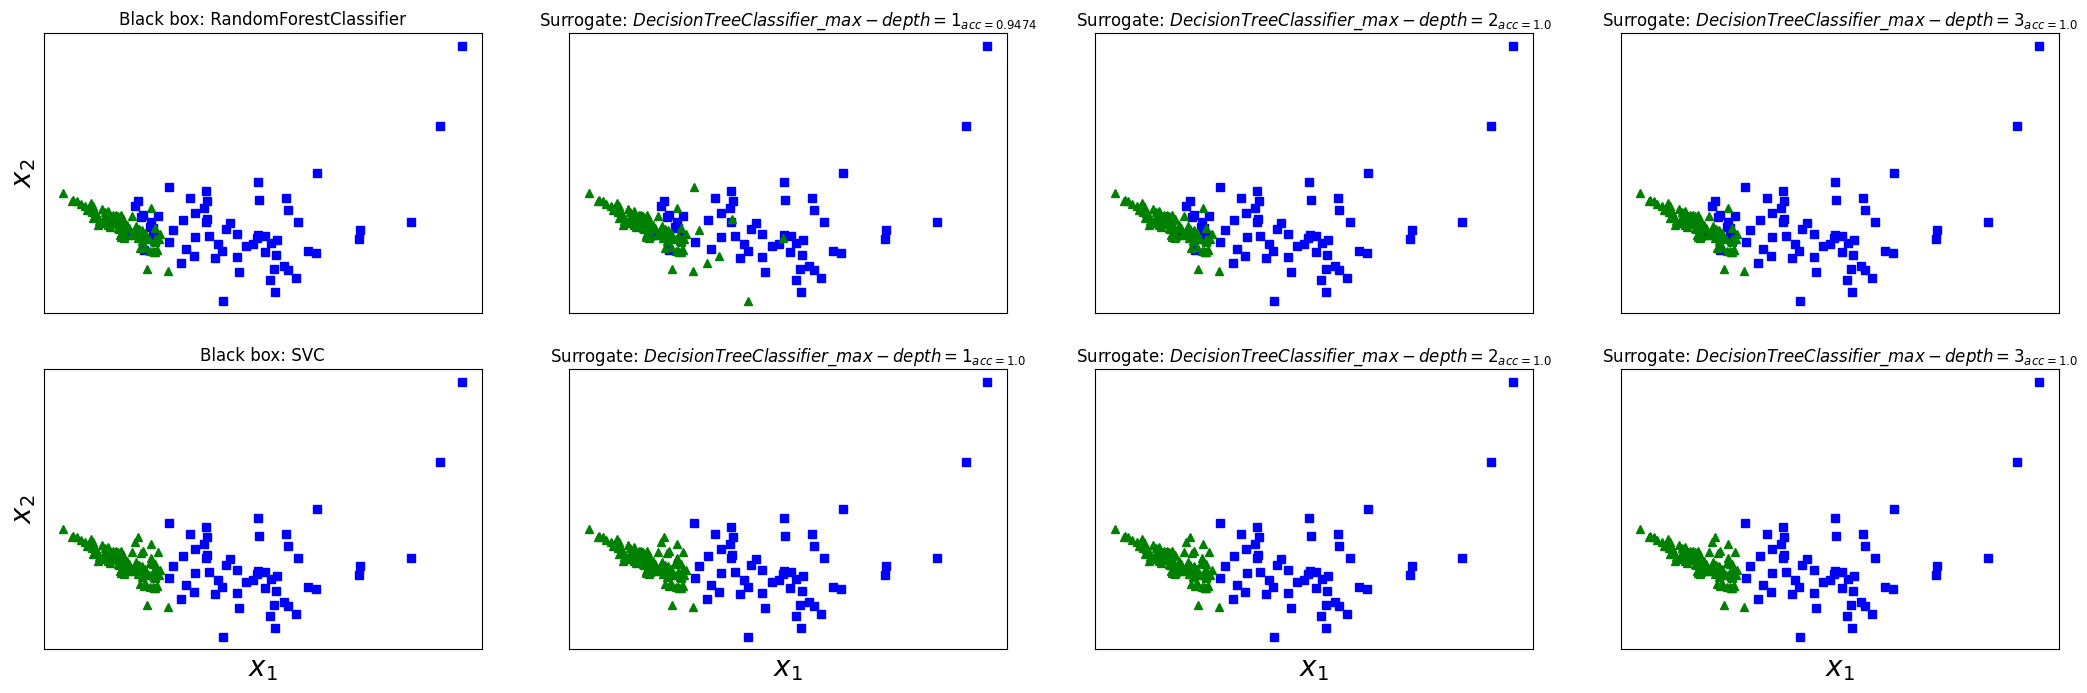

In [88]:
for bidx, (b_name, b_yhat) in enumerate(black_yhat.items()):
    axes_bc[bidx, 0].plot(
        X_pca[:, 0][b_yhat == 0], X_pca[:, 1][b_yhat == 0], "bs"
    )
    axes_bc[bidx, 0].plot(
        X_pca[:, 0][b_yhat != 0], X_pca[:, 1][b_yhat != 0], "g^"
    )
    for widx, (w_name, w_model) in enumerate(white_yhat.items()):
        axes_bc[bidx, widx + 1].plot(
            X_pca[:, 0][w_model[b_name] == 0], X_pca[:, 1][w_model[b_name] == 0], "bs"
        )
        axes_bc[bidx, widx + 1].plot(
            X_pca[:, 0][w_model[b_name] != 0], X_pca[:, 1][w_model[b_name] != 0], "g^"
        )
        axes_bc[bidx, widx + 1].tick_params(**tick_params)
        text = f"Surrogate: ${_names[w_name]}"
        text += "_{acc="
        text += f"{round(accuracy_score(b_yhat, w_model[b_name]), 4)}"
        text += "}$"
        axes_bc[bidx, widx + 1].set_title(text)

    axes_bc[bidx, 0].tick_params(**tick_params)
    axes_bc[bidx, 0].set_ylabel(r"$x_2$", fontsize=20)
    if bidx == len(black_yhat.items()) - 1:
        for ax in axes_bc[bidx, :]:
            ax.set_xlabel(r"$x_1$", fontsize=20)
    axes_bc[bidx, 0].set_title(f"Black box: {_names[b_name]}")
fig_bc

Acima, temos os gráficos em $\mathbb{R}^{2}$ do conjunto de dados sob o connjunto de teste colorido por seus respectivos labels. A primeira linha de gráficos trata-se do modelo *Random Forest* e as colunas são os modelos *white box*, e os labels classificados, auemntando a profundidade da arvore, aonde o intuito é aproximar o comportamento do modelo caixa preta; além disso, foi adicionado em subescrito a acuracia referente as classificações obtidas pelo respectivo modelo *white box* versus o verdadeiro obtido pelo modelo *black box*.

Para a primeira linha, é possível notar que para uma profundidade de 2 niveis, podemos ja replicar com tranquilidade o modelo caixa preta, sem perdermos resultados para esse conjutno de dados, e tambem diminuindo complexidade no modelo final. Já para o *SVC* já é possível ver que a arvore de decisão já consegui replicar com tranquilidade o modelo caixa preta, considerando apenas 1 nivel de profundidade.

### 2.4 Arvore de decisão obtida para ambos modelos *black box*

In [89]:
fig_tree, axes_tree = plt.subplots(len(black_box.keys()), len(white_box_models.keys()), figsize=(16, 8))
plt.close()

In [90]:
if isinstance(axes_tree, plt.Axes):
    axes_tree = np.array([[axes_tree]])
elif axes_tree.ndim == 1:
    axes_tree = axes_tree.reshape(1, -1)

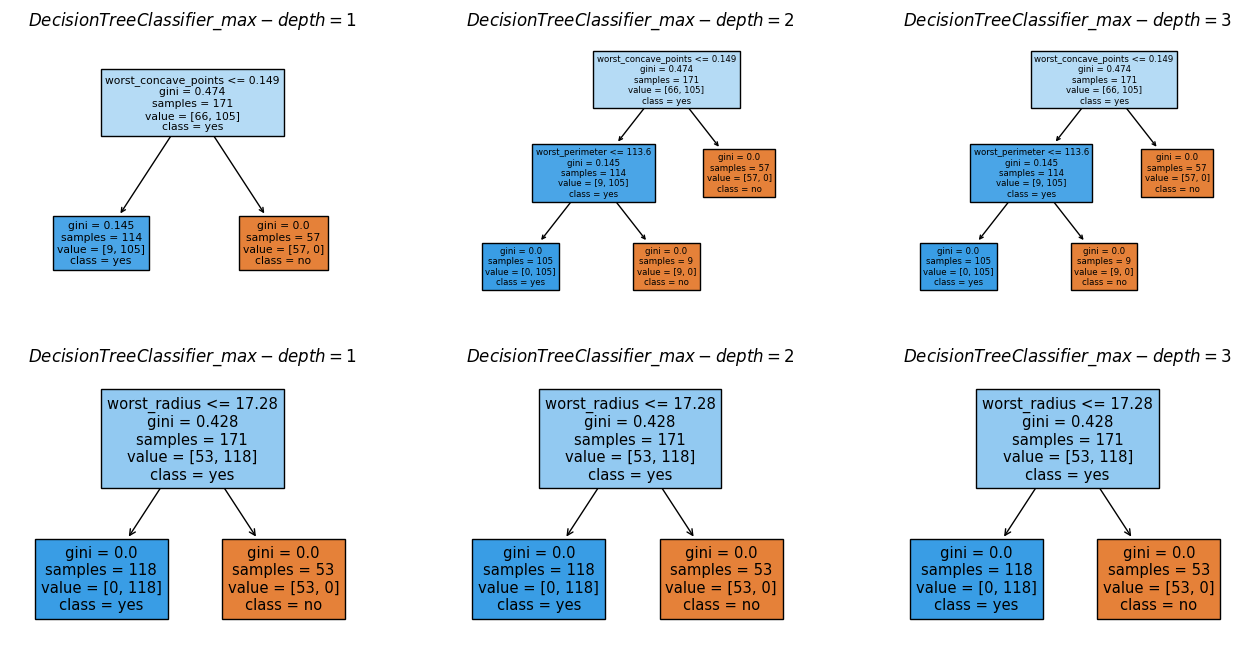

<Figure size 640x480 with 0 Axes>

In [91]:
for b_idx, (b_name, b_model) in enumerate(black_box.items()):
    for w_idx, (w_name, w_model) in enumerate(white_box_models.items()):
        plot_tree(
            w_model[b_name],
            feature_names=X.columns,
            class_names=['no', "yes"],
            filled=True,
            ax=axes_tree[b_idx, w_idx]
        )
        axes_tree[b_idx, w_idx].set_title(f"${_names[w_name]}$")
plt.tight_layout()
fig_tree

Acima podemos ver os nós das arvores para cada modelo caixa preta, sendo respectivamente o *Random Forest* e o *SVC* respectivamente. É possivel notar para o *SVC*, que a arvore de decisão apresentou um impureza nula, para ambas as classes, para apenas 1 nivel de profundidade, e para o *Random Forest*, bastou apenas 2 níveis.

## 3. Superficie de separação

Nesta seção, vamos gerar um conjunto de dados sintetico clássico (*Noisy Circles*), treinar um modelo *black box* e *white box*. Apos o treinamento, vamos gerar um numero maior de instancias apartir de uma uniforme definida entre 0 e 1 para poder comparar a superficie de separação o *surrogate* e o *black box*.

### 3.1 Aproximando o *white box*


No experimento abaixo, vamos adicionar mais arvores de decisoes, aumentando o numero de profundidade, com o intuito de simular ainda mais proximo o resultado do modelo caixa preta.

In [92]:
n_samples_train = 5000
n_samples_test = 5000
train_seed = 30
test_seed = 31
_params = {
    "factor": 0.6,
    "noise": 0.05
}

In [93]:
max_depth = 6
white_box = {
    f"dt{i}": DecisionTreeClassifier(max_depth=i, random_state=n_seed) for i in range(1, max_depth + 1)
}

_names = {
    "rf": "RandomForestClassifier",
    "dt": "DecisionTreeClassifier",
    "svc": "SVC"
}
_names.update(
    {f"dt{i}": fr"DecisionTreeClassifier\_max-depth={i}" for i in range(1, max_depth + 1)}
)

In [94]:
noise_params = {
    "train": {"random_state": train_seed, "n_samples": n_samples_train},
    "test": {"random_state": test_seed, "n_samples": n_samples_test}
}
noise_params["train"].update(_params)
noise_params["test"].update(_params)

In [95]:
train_noisy_circles, train_nc_labels = make_circles(
    **noise_params["train"]
)

test_noisy_circles, test_nc_labels = make_circles(
    **noise_params["test"]
)

In [96]:
##################################################
# Nesse trecho, é treinado os modelos sorragates
##################################################
white_box_models, black_box_models, white_yhat, black_yhat = train_surrogates(
    white_box,
    black_box,
    train_noisy_circles,
    train_nc_labels,
    test_noisy_circles
)

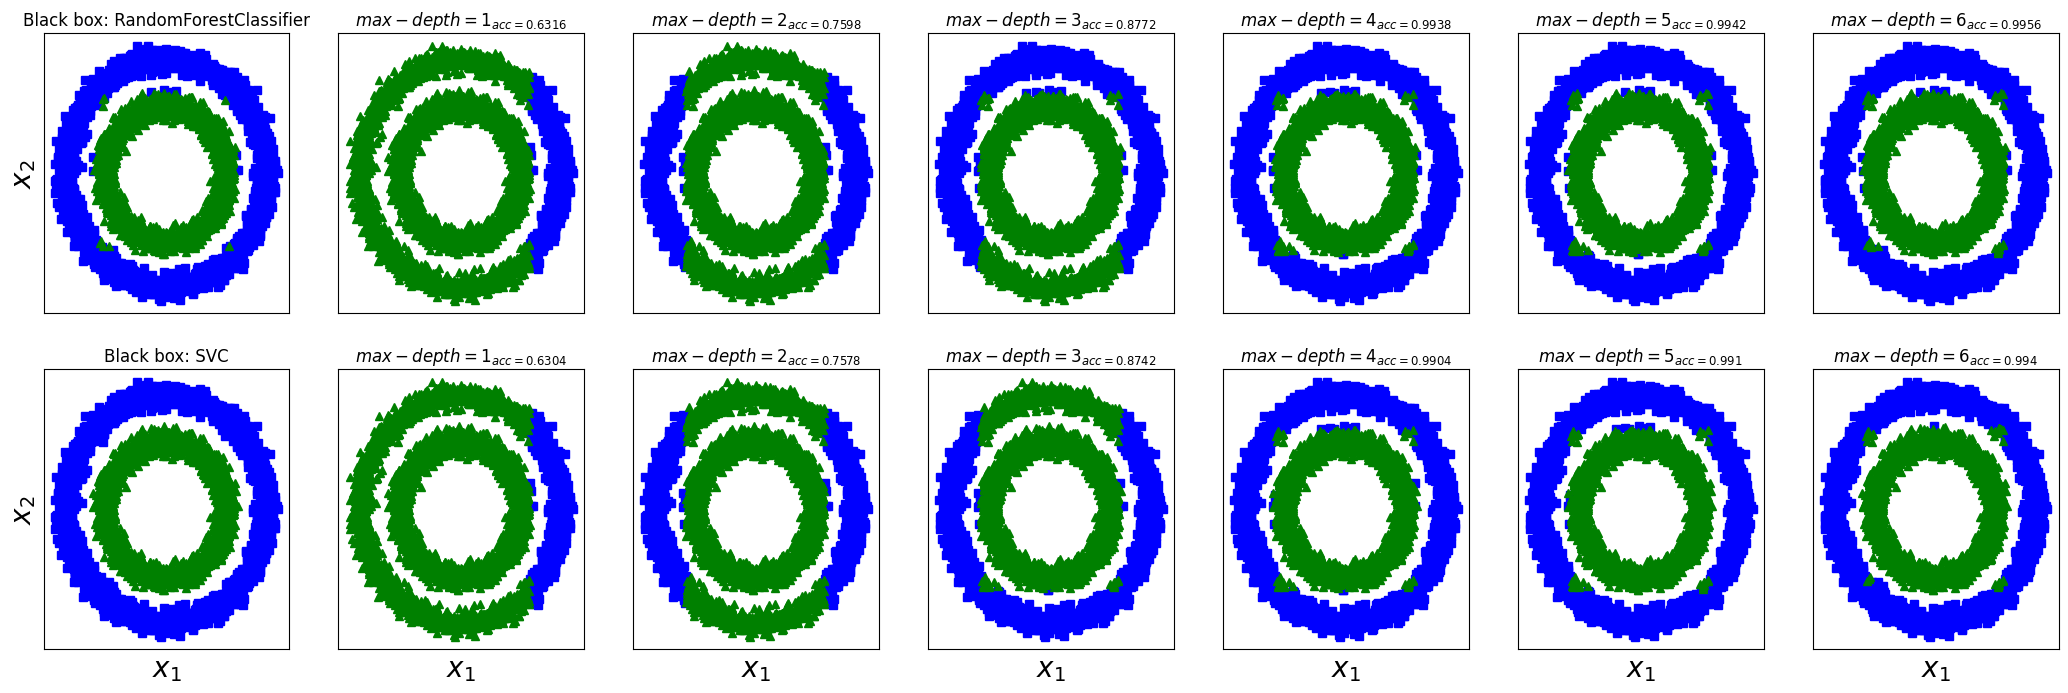

In [97]:
fig_circles, axes_circles = plot_results(
    black_yhat,
    white_yhat,
    test_noisy_circles,
    tick_params,
    _names,
    figsize=(26, 8)
)
fig_circles

### 3.2 Aumentando o número de dados

In [98]:
n, c = 5000, train_noisy_circles.shape[1]
xy_min = train_noisy_circles.min(axis=0)
xy_max = train_noisy_circles.max(axis=0)

In [99]:
X_simulated = np.random.uniform(
    low=xy_min,
    high=xy_max,
    size=(n, c)
)

### 3.3 Predições

In [100]:
bs_yhat = {}
for bs_name, bs_model in black_box_models.items():
    bs_yhat[bs_name] = bs_model.predict(X_simulated)

In [101]:
ws_yhat = {}
for ws_name, ws_model in white_box_models.items():
    ws_yhat[ws_name] = {}
    for bs_name, bs_model in ws_model.items():
        ws_yhat[ws_name][bs_name] = bs_model.predict(X_simulated)

### 3.4 Plot

In [102]:
fig, axes = plt.subplots(len(bs_yhat.keys()), len(ws_yhat.keys()) + 1, figsize=(12, 6))
plt.close()

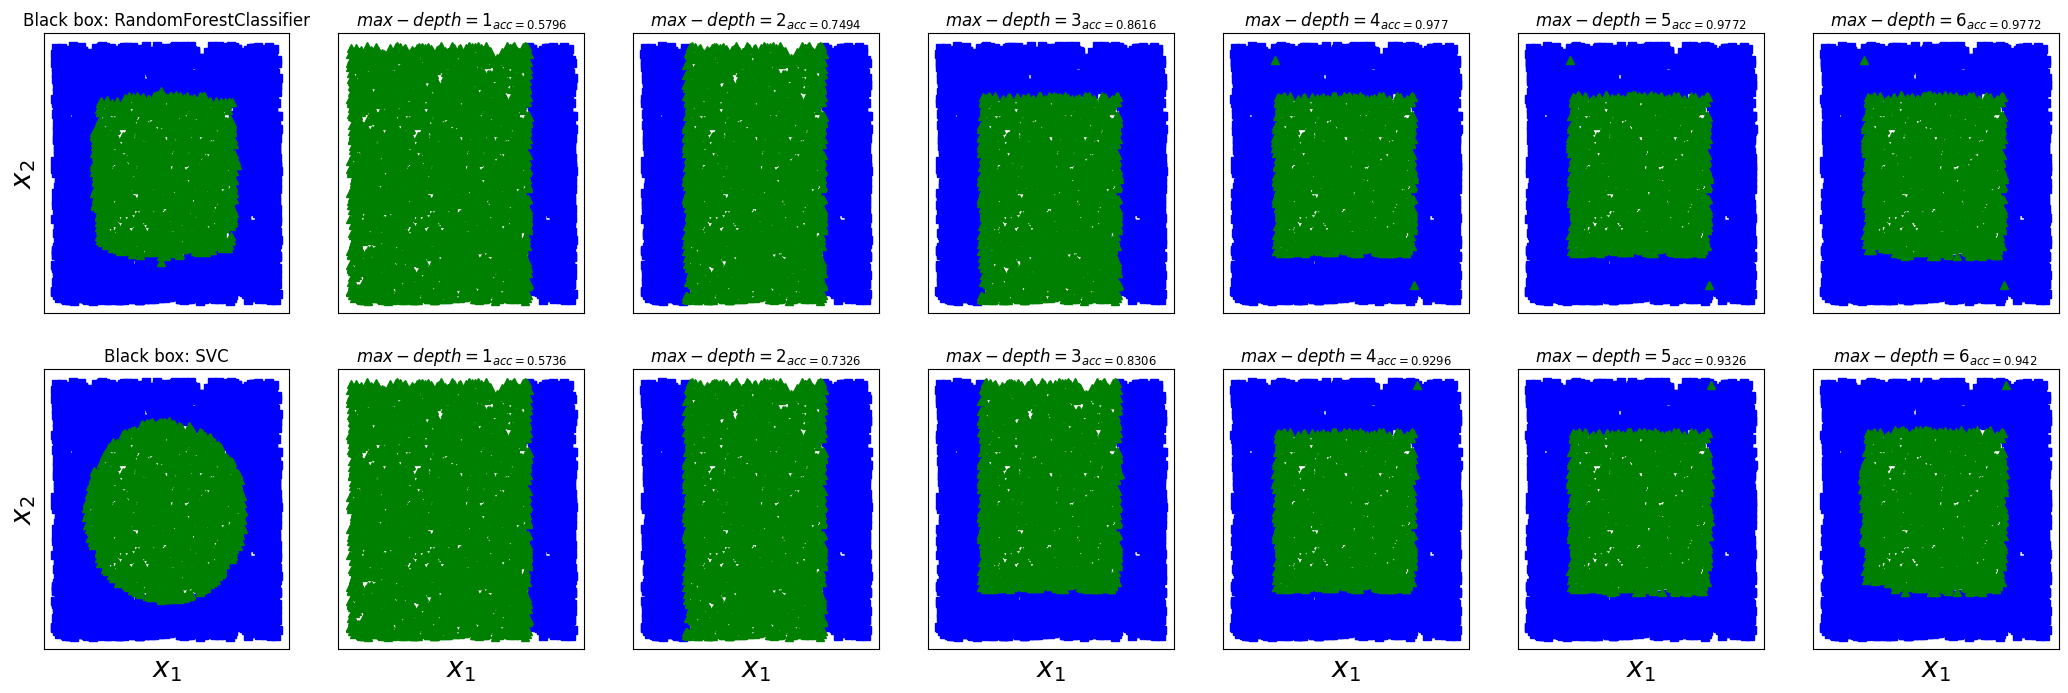

In [103]:
fig_simu, axes_simu = plot_simulation_results(
    bs_yhat,
    ws_yhat,
    X_simulated,
    tick_params,
    _names,
    figsize=(26, 8)
)
fig_simu

Podemos notar que o *Random Forest* sob  o conjunto uniformemente distribuido, identificou um grupo em formato de cubo inscrito dentro do cubo maior e o *SVC* similar, contudo circunscrito no quadrado maior. Ao olhar para os modelos caixa branca, é possivel notar o "trajeto" que o modelo levou para identificar o quadrado interno como o segundo grupo para o Random Forest, e conseguiu se aproximar significantemente do resultado do modelo caixa preta. Já analisando o *SVC*, ele conseguiu identificar o subgrupo mas nao conseguiu definir o formato dele, possivelmente pela diferença entre as naturezas dos algoritmos, aonde o *SVC* busca traçar um hiperplano que consiga dividar as caracteristicas dos grupos diferente da Arvore de decisãp,  que busca subdividar os dados em subconjuntos homogeneos.

##  4. Conclusões

Para o problema do breast cancer, foi aplicado dois modelos de caixa preta, *SVC* e o *Random Forest*, e para o modelo caixa branca, foi aplicado variações de profundidade de Arvores de Decisão. Ao decorrer da atividade, é possivel notar o quão interessante é método de *Surrogates*, aonde é possivel reduzir bastante o custo computacional, uma vez que é possivel aproximar modelos caixa preta  por meio de métodos além de ser mais interpretaveis, menos custosos.

Além de ser menos custoso, o método nos proporciona a possibilidade de, por meio de métodos interpretaveis, aproximar como o modelo caixa preta tomou certas decisões para determinada classificação de uma instância. 

Ao olhar a subseção `2.4`, é possível notar que apartir de uma profundidade de 2 dois nós, o método caixa branca conseguiu estimar bem o comportamento do modelo caixa preta, considerando as variáveis *worst concave points* e *worst perimeter* mais decisorias e importantes para a separação dos tipos de cancer, respectivamente.